In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn import preprocessing
import math

In [31]:
brm = pd.read_csv("../generated/brm_cleaned.csv") # letzter Plot gibt keine Ergebnisse
frb = pd.read_csv("../generated/frb_cleaned.csv")

## Demand

In [32]:
def calc_demand(frame):
    frame["trip_duration"] = frame["trip_duration"].apply(pd.Timedelta) #convert time column to a useful type
    daily_driven = frame.groupby("day").agg({"trip_duration":"sum"}) #aggregate daily driven time
    #For a more detailed aggregation we add a daytime to the variables, so we can calculate time driven by daytime.
    #This also allows a better mapping of how weather effects demand.
    morning = frame[(frame["time"] > "06:00:00") & (frame["time"] <= "11:00:00")] #saving rows where time is in defined range to a new df
    noon = frame[(frame["time"] > "11:00:00") & (frame["time"] <= "16:00:00")]
    evening = frame[(frame["time"] > "16:00:00") & (frame["time"] <= "21:00:00")]
    night = frame[(frame["time"] > "21:00:00")] + frame[(frame["time"] <= "06:00:00")]
    for i in morning.index: # using indexes from lists above to cycle through the whole data
       frame.at[i , "daytime"] = 0 # morning refers to 0
    for i in noon.index:
       frame.at[i , "daytime"] = 1 # noon -> 1
    for i in evening.index:
       frame.at[i , "daytime"] = 2 # evening -> 2
    for i in night.index:
       frame.at[i , "daytime"] = 3 # night -> 3
    frame["daytime"] = frame["daytime"].map(lambda x: (int(x))) #map integer for daytime instead of float
    return frame

summarizing data over day and daytime via aggregation of the trip durations taken.

In [33]:
frb_demand = calc_demand(frb)
frb_daytime_driven = frb_demand.groupby(["day","daytime"]).agg({"trip_duration":"sum"})
frb_daytime_driven["trip_duration"] = frb_daytime_driven["trip_duration"].astype(str).str.extract("days (.*?)\.")

In [34]:
brm_demand = calc_demand(brm)
brm_daytime_driven = brm_demand.groupby(["day","daytime"]).agg({"trip_duration":"sum"})
brm_daytime_driven["trip_duration"] = brm_daytime_driven["trip_duration"].astype(str).str.extract("days (.*?)\.")

export data by hours and summarizing the trips taken in these time sections

In [35]:
frb_demand["hour"] = frb_demand["time"].str[:-6]
frb_hourly_driven = frb_demand.groupby(["day","hour"]).agg({"trip_duration":"sum"})
frb_hourly_driven.to_csv("../generated/frb_hourly_driven.csv")

In [36]:
brm["hour"] = brm["time"].str[:-6]
brm_hourly_driven = brm.groupby(["day","hour"]).agg({"trip_duration":"sum"})
brm_hourly_driven.to_csv("../generated/brm_hourly_driven.csv")

## Weather

In [37]:
brm_precipitation = pd.read_csv("../resources/bremen_precipitation.csv")
frb_precipitation = pd.read_csv("../resources/freiburg_precipitation.csv")

brm_temperature = pd.read_csv("../resources/bremen_temperature.csv")
frb_temperature = pd.read_csv("../resources/freiburg_temperature.csv")

schwarme_precipitation = pd.read_csv("../resources/schwarme_precipitation.csv")
bassum_precipitation = pd.read_csv("../resources/bassum_precipitation.csv")

Defining methods to join bike_data and weather data

In [38]:
def cut_timestamp(timestamp_col):
    return timestamp_col.map(lambda x:int(str(x)[:10]))

def assemble_timestamp_cut(day_frame, time_frame):
    day_clean = day_frame.map(lambda x: x.replace("-", ""))
    hour = time_frame.map(lambda x: x.replace(":", "")[:2])
    return (day_clean + hour).astype("int64")

def join_by_hour(bike_frame, weather_frame, column_name):
    bike_frame["timestamp_cut"] = assemble_timestamp_cut(bike_frame["day"], bike_frame["time"])
    weather_frame["timestamp_cut"] = cut_timestamp(weather_frame["Zeitstempel"])
    
    joined = bike_frame.join(weather_frame[["Wert", "timestamp_cut"]].set_index("timestamp_cut"), on="timestamp_cut")
    joined[column_name] = joined["Wert"]
    
    joined = joined.drop("Wert", axis=1)
    joined = joined.drop("timestamp_cut", axis=1)
    
    return joined

Identifying missing values

In [39]:
# create a dataframe which contains all dates from 2019-01-20 until 2020-01-20
all_dates_frame = pd.DataFrame(pd.date_range(
    start = datetime.strptime("2019-01-20 00", "%Y-%m-%d %H"), 
    end = datetime.strptime("2020-01-20 00", "%Y-%m-%d %H"),
    freq="1h"), columns=["date"])

all_dates_frame["Zeitstempel"] = all_dates_frame["date"].map(lambda x: int(x.strftime("%Y%m%d%H%M")))
all_dates_frame = all_dates_frame.drop("date", 1)

# loading precipitation data of bremen and mark missing values
brm_precipitation_full = brm_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
brm_precipitation_full = brm_precipitation_full.set_index("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.sort_values("Zeitstempel")
brm_precipitation_full = brm_precipitation_full.reset_index()

brm_precipitation_full[brm_precipitation_full["Wert"].isnull()]

,Zeitstempel,Produkt_Code,SDO_ID,Wert,Qualitaet_Niveau,Qualitaet_Byte
439,201902070700,NaN,NaN,NaN,NaN,NaN
440,201902070800,NaN,NaN,NaN,NaN,NaN
441,201902070900,NaN,NaN,NaN,NaN,NaN
442,201902071000,NaN,NaN,NaN,NaN,NaN
443,201902071100,NaN,NaN,NaN,NaN,NaN
452,201902072000,NaN,NaN,NaN,NaN,NaN
453,201902072100,NaN,NaN,NaN,NaN,NaN
454,201902072200,NaN,NaN,NaN,NaN,NaN
455,201902072300,NaN,NaN,NaN,NaN,NaN


In [40]:
brm_sub_frame = brm_precipitation_full[(brm_precipitation_full["Zeitstempel"] >= 201902070000) & (brm_precipitation_full["Zeitstempel"] <= 201902080300)]

Getting data from station of schwarme and station of bassum

In [41]:
# loading precipitation data of schwarme and mark missing values
schwarme_precipitation_full = schwarme_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
schwarme_precipitation_full = schwarme_precipitation_full.set_index("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.sort_values("Zeitstempel")
schwarme_precipitation_full = schwarme_precipitation_full.reset_index()

bassum_precipitation_full = bassum_precipitation.join(all_dates_frame.set_index("Zeitstempel"), on="Zeitstempel", how="outer")
bassum_precipitation_full = bassum_precipitation_full.set_index("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.sort_values("Zeitstempel")
bassum_precipitation_full = bassum_precipitation_full.reset_index()

Finding the station which has approximately the same precipitation than the station of bremen

In [42]:
schwarme_sub_frame = schwarme_precipitation_full[(schwarme_precipitation_full["Zeitstempel"] >= 201902070000) & (schwarme_precipitation_full["Zeitstempel"] <= 201902080300)]
bassum_sub_frame = bassum_precipitation_full[(bassum_precipitation_full["Zeitstempel"] >= 201902070000) & (bassum_precipitation_full["Zeitstempel"] <= 201902080300)]

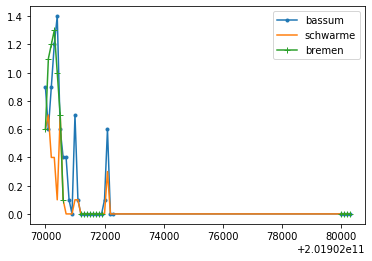

In [43]:
plt.plot(bassum_sub_frame["Zeitstempel"], bassum_sub_frame["Wert"], '.-', label="bassum")
plt.plot(schwarme_sub_frame["Zeitstempel"], schwarme_sub_frame["Wert"], '-', label="schwarme")
plt.plot(brm_sub_frame["Zeitstempel"], brm_sub_frame["Wert"], '+-', label="bremen")

plt.legend()
plt.show()

Since precipitiation of bassum fits more the precipitation of bremen we choose to replace missing values of bremen with values of bassum

In [44]:
brm_precipitation_full[brm_precipitation_full["Wert"].isnull()] = bassum_precipitation_full
brm_precipitation_full[brm_precipitation_full["Wert"].isnull()]

,Zeitstempel,Produkt_Code,SDO_ID,Wert,Qualitaet_Niveau,Qualitaet_Byte


combine missing values of brm_precipitation with precipitation values from the city of schwarme

In [45]:
brm_precipitation = join_by_hour(brm, brm_precipitation_full, "precipitation")
brm_weather = join_by_hour(brm_precipitation, brm_temperature, "temperature")
brm_weather.to_csv("../generated/bremen_weather.csv")

In [46]:
frb_precipitation = join_by_hour(frb, frb_precipitation, "precipitation")
frb_weather = join_by_hour(frb_precipitation, frb_temperature, "temperature")
frb_weather.to_csv("../generated/freiburg_weather.csv")

bring files in same shape as files from demand for merging them

In [47]:
frb_weather["hour"] = frb_weather["time"].str[:-6]
frb_hourly_weather = frb_weather.groupby(["day","hour"]).agg({"precipitation":"mean","temperature":"mean"})
frb_hourly_weather.to_csv("../generated/frb_hourly_weather.csv")

In [48]:
brm_weather["hour"] = brm_weather["time"].str[:-6]
brm_hourly_weather = brm_weather.groupby(["day","hour"]).agg({"precipitation":"mean","temperature":"mean"})
brm_hourly_weather.to_csv("../generated/brm_hourly_weather.csv")

## Demand and Weather
Load generated Files from before:

In [49]:
brm_hourly_weather = pd.read_csv("../generated/brm_hourly_weather.csv")
frb_hourly_weather = pd.read_csv("../generated/frb_hourly_weather.csv")

brm_hourly_driven = pd.read_csv("../generated/brm_hourly_driven.csv")
frb_hourly_driven = pd.read_csv("../generated/frb_hourly_driven.csv")

### functions for dataframes and plots:

In [50]:
def create_data(drivenframe,weatherframe): #input weather and driven data from demand
    drivenframe["trip_duration"] = drivenframe["trip_duration"].apply(pd.Timedelta)
    combined = weatherframe.join(drivenframe["trip_duration"]) #join dataframes
    daily = combined.groupby("day").agg({"trip_duration":"sum","precipitation":"mean","temperature":"mean"}) #group and aggregate data
    daily["trip_duration_in_hours"] = daily["trip_duration"].map(lambda x: (x.total_seconds() / 60 / 60))# calc trip duration in hours
    daily = daily.reset_index() #reset index
    daily["day"] = pd.to_datetime(daily["day"])
    daily["week"] = daily["day"].map(lambda x: (x.strftime("%W"))) #make 2 new colums so we can aggregate weekly
    daily["year"] = daily["day"].map(lambda x: (x.strftime("%Y")))
    
    weekly = daily.groupby(["year","week"]).agg({"trip_duration_in_hours":"sum","precipitation":"sum","temperature":"mean"})#aggergate data weekly
    weekly = weekly.reset_index() 
    return [daily,weekly]

def create_plot(frame,column,title): #dataframe, column for x axis and title of the plot
    values = frame[["precipitation","temperature","trip_duration_in_hours"]].values# get values from frame
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) #define scaler(normalize data)...
    scaled = scaler.fit_transform(values)
    demand = pd.DataFrame(scaled)
    plt.figure(figsize=(16,8))
    plt.plot(column,demand[0],label = "precipitation |"
         + " min: " + str(frame["precipitation"].min()) 
         + ", max: " + str(frame["precipitation"].max()))
    plt.plot(column,demand[1],label = "temperature |"
         + " min: " + str(math.floor(frame["temperature"].min())) 
         + ", max: " + str(math.floor(frame["temperature"].max())))
    plt.plot(column,demand[2],label = "trip in hours |"
         + " min: " + str(math.floor(frame["trip_duration_in_hours"].min())) 
         + ", max: " + str(math.floor(frame["trip_duration_in_hours"].max())))
    plt.ylabel('normalized value')
    plt.title(title)
    plt.legend()
    plt.show()
    
def increment_week(frame): #add 53 to weeks in 2020 so we can plot it with week as counter 
    for i in frame.index:
        #chech for the correct year and if the function has been already applied
        if((frame.at[i,"year"]== "2020") and (int(frame.at[i,"week"]) < 52)):
            frame.at[i,"week"] = str(int(frame.at[i,"week"]) + 53)

In [51]:
brm_daily = create_data(brm_hourly_driven,brm_hourly_weather)[0]
brm_weekly = create_data(brm_hourly_driven,brm_hourly_weather)[1]

frb_daily = create_data(frb_hourly_driven,frb_hourly_weather)[0]
frb_weekly = create_data(frb_hourly_driven,frb_hourly_weather)[1]

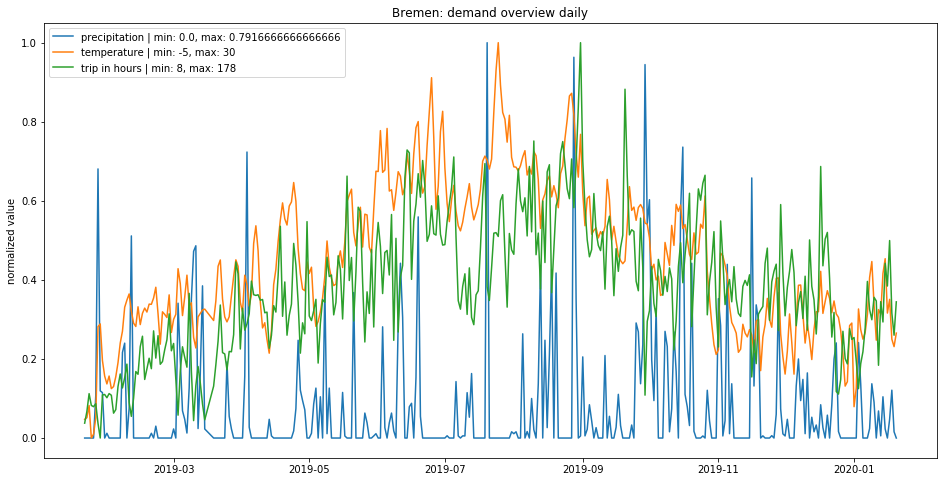

In [52]:
create_plot(brm_daily,brm_daily["day"],"Bremen: demand overview daily")

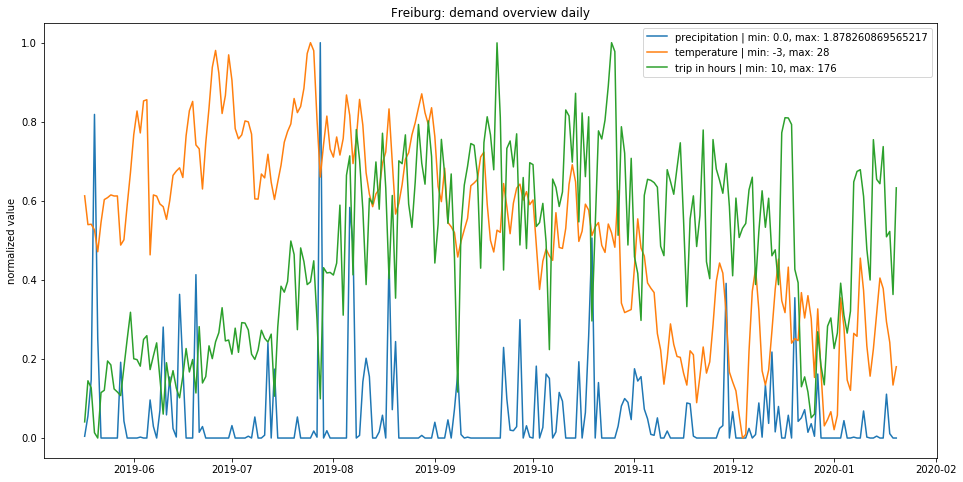

In [53]:
create_plot(frb_daily,frb_daily["day"],"Freiburg: demand overview daily")

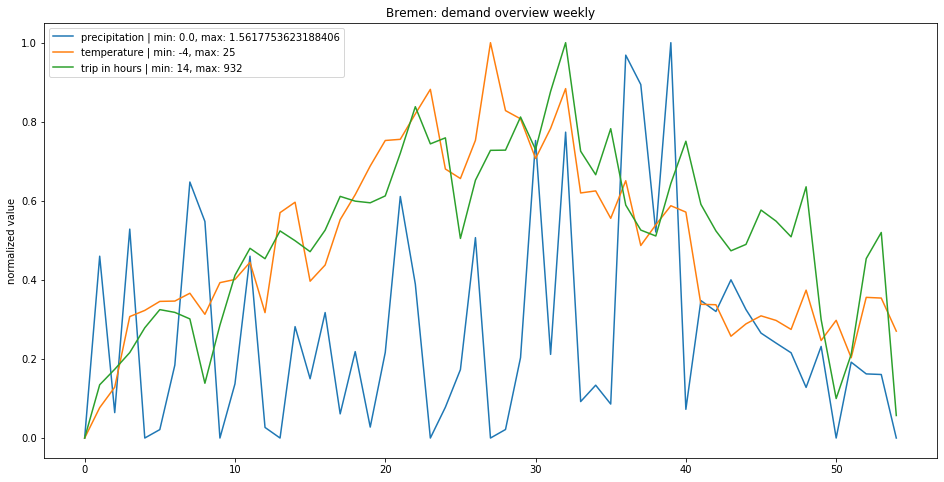

In [54]:
create_plot(brm_weekly,brm_weekly.index,"Bremen: demand overview weekly")

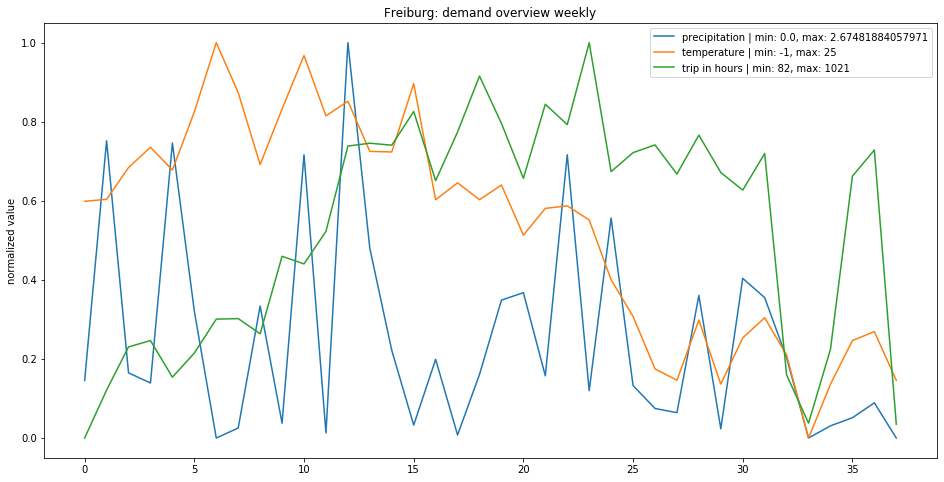

In [55]:
create_plot(frb_weekly,frb_weekly.index,"Freiburg: demand overview weekly")

In [56]:
increment_week(brm_weekly)
increment_week(frb_weekly)

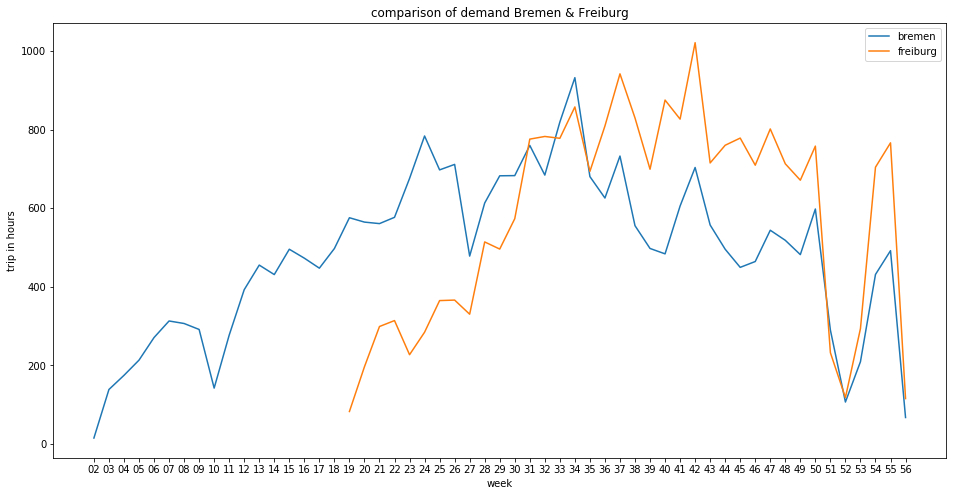

In [57]:
plt.figure(figsize=(16,8))
plt.plot(brm_weekly["week"],brm_weekly["trip_duration_in_hours"],label="bremen")
plt.plot(frb_weekly["week"],frb_weekly["trip_duration_in_hours"],label="freiburg")
plt.xlabel('week')
plt.ylabel('trip in hours')
plt.title('comparison of demand Bremen & Freiburg')
plt.legend()
plt.show()

In [58]:
print("Number of Bikes: " + str(len(brm["b_number"].unique())) + " Bremen" + " vs. " + str(len(frb["b_number"].unique())) + " Freiburg")

Number of Bikes: 441 Bremen vs. 435 Freiburg


As we can see the data for Freiburg started at 6.5.2019 which is week 18 in our plot.
After that we have a strong increase and in total more triptime than bremen even if the population is much lower in Freiburg (230k vs. 550k) altough the number of bikes is nearly the same (as seen above). In the Winterholidays there are clearly less bikes users in both cities. The high difference in triptime at week 35+ could relate with the higher temperatures in Freiburg during that time.